In [1]:
from monostable_model import ion_channel_model, model_force_square, random_force_gauss, random_force_levy
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown, SelectionSlider


def ion_channel_interactive(
    a, closed_0, closed_1, opened_0, opened_1, D, delta_t, records, model_force, random_force
):
    closed = (closed_0, closed_1)
    opened = (opened_0, opened_1)
    ion_channel_model(a, closed, opened, D, delta_t, records, model_force, random_force)

# Interact with the function
interact(
    ion_channel_interactive,
    a=FloatSlider(min=0.1, max=10.0, step=0.1, value=1, description='a'),
    closed_0=IntSlider(min=-10, max=10, step=1, value=-1, description='Closed value'),
    closed_1=IntSlider(min=1000, max=10000, step=500, value=5000, description='Closed time scale'),
    opened_0=IntSlider(min=-10, max=10, step=1, value=1, description='Opened value'),
    opened_1=IntSlider(min=1000, max=10000, step=500, value=2500, description='Opened time scale'),
    D=FloatSlider(min=0.1, max=2.0, step=0.1, value=0.5, description='D'),
    delta_t=SelectionSlider(
        options=[10**-i for i in range(1, 5)],
        value=0.01,
        description='Delta t',
    ),
    records=IntSlider(min=1000, max=100000, step=1000, value=50000, description='Records'),
    model_force=Dropdown(
        options={'Square Force': model_force_square, 'Other Force': lambda x: x**2},
        value=model_force_square,
        description='Model Force',
    ),
    random_force=Dropdown(
        options={'Gauss Force': random_force_gauss, 'Levy Force': random_force_levy},
        value=random_force_gauss,
        description='Random Force',
    ),
)

interactive(children=(FloatSlider(value=1.0, description='a', max=10.0, min=0.1), IntSlider(value=-1, descript…

<function __main__.ion_channel_interactive(a, closed_0, closed_1, opened_0, opened_1, D, delta_t, records, model_force, random_force)>

KeyboardInterrupt: 

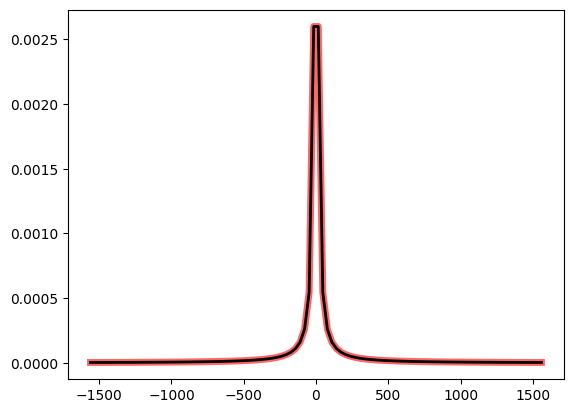

In [111]:
import numpy as np
from scipy.stats import levy_stable
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

alpha, beta = 0.5, 0
loc, scale = 0, 1
x = np.linspace(levy_stable.ppf(0.01, alpha, beta, loc=loc, scale=scale),
                levy_stable.ppf(0.99, alpha, beta, loc=loc, scale=scale), 100)
ax.plot(x, levy_stable.pdf(x, alpha, beta, loc=loc, scale=scale),
       'r-', lw=5, alpha=0.6, label='levy_stable pdf')

rv = levy_stable(alpha, beta, loc=loc, scale=scale)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

vals = levy_stable.ppf([0.001, 0.5, 0.999], alpha, beta, loc=loc, scale=scale)
np.allclose([0.001, 0.5, 0.999], levy_stable.cdf(vals, alpha, beta, loc=loc, scale=scale))

r = levy_stable.rvs(alpha, beta, loc=loc, scale=scale, size=1000)
ax.hist(r, density=True, bins="auto", histtype='stepfilled', alpha=0.2)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)
plt.show()

In [2]:
import numpy as np
import plotly.graph_objects as go
from scipy.stats import levy_stable

# Parameters
alpha, beta = 2, 0
loc, scale = 0, 1

# Generate data for PDF
x = np.linspace(levy_stable.ppf(0.01, alpha, beta, loc=loc, scale=scale),
                levy_stable.ppf(0.99, alpha, beta, loc=loc, scale=scale), 100)
pdf = levy_stable.pdf(x, alpha, beta, loc=loc, scale=scale)

# Generate random samples
r = levy_stable.rvs(alpha, beta, loc=loc, scale=scale, size=100)

# Create the figure
fig = go.Figure()

# Add PDF curve
fig.add_trace(go.Scatter(x=x, y=pdf, mode='lines', name='Lévy-stable PDF'))

# Add histogram
fig.add_trace(go.Histogram(x=r, histnorm='probability density', opacity=0.6, name='Histogram'))

# Customize layout
fig.update_layout(
    title="Interactive Lévy-Stable Distribution",
    xaxis_title="Value",
    yaxis_title="Density",
    legend=dict(x=0.02, y=0.98),
    template="plotly_dark"
)

# Show interactive plot
fig.show()


In [71]:
random_force_gauss(0.5, 0.01)

0.024351238081335862

In [82]:
import importlib
import monostable_model
importlib.reload(monostable_model)


monostable_model.random_force_levy(0.5, 0.01)

-0.008447132207085262